# U-Net image segmentation

In [1]:
%matplotlib inline

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50
import json

In [3]:
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True

## Data pre-processing

In [4]:
PATH = Path('data/carvana/')

In [5]:
list(PATH.iterdir())

[PosixPath('data/carvana/train_masks.csv'),
 PosixPath('data/carvana/train_masks-128'),
 PosixPath('data/carvana/train-128'),
 PosixPath('data/carvana/train'),
 PosixPath('data/carvana/train_hq'),
 PosixPath('data/carvana/train_masks_png'),
 PosixPath('data/carvana/tmp'),
 PosixPath('data/carvana/models'),
 PosixPath('data/carvana/train_masks')]

In [6]:
MASK_FN = 'train_masks.csv'
TRAIN_DIRNAME = 'train'
MASK_DIRNAME = 'train_masks'

In [7]:
mask_csv = pd.read_csv(PATH/MASK_FN)

In [8]:
mask_csv.head(2)

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...


In [ ]:
list((PATH/TRAIN_DIRNAME).iterdir())[:5]

In [ ]:
CAR_ID = "d61b6bfeabb2"

In [9]:
def show_img(img, figsize=None, ax=None, alpha=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img, alpha=alpha)
    ax.set_axis_off()
    return ax

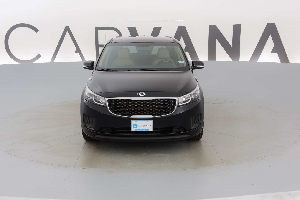

In [12]:
Image.open(PATH/TRAIN_DIRNAME/f'{CAR_ID}_01.jpg').resize((300, 200))

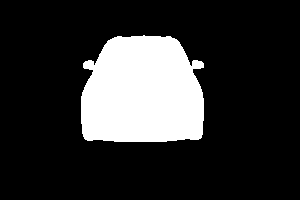

In [13]:
Image.open(PATH/MASK_DIRNAME/f'{CAR_ID}_01_mask.gif').resize((300, 200))

**The cars are shown in 16 different positions:**

In [14]:
imgs = [open_image(PATH/TRAIN_DIRNAME/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]

02d formats an integer (d) to a field of minimum width 2 (2), with zero-padding on the left (leading 0)

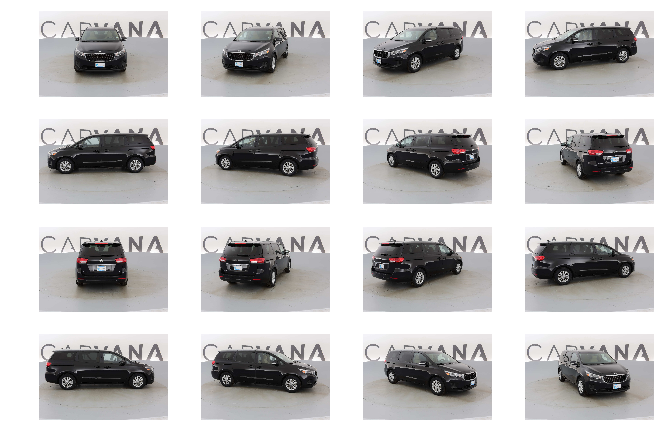

In [15]:
fig, axes = plt.subplots(4, 4, figsize=(9,6))
for i,ax in enumerate(axes.flat):
    show_img(imgs[i], ax=ax)
plt.tight_layout(pad=0.1)

### Resize and convert
1. Convert a smaller sized dataset (128x128) for faster experimentation followed by *progressive resizing*.
1. Convert gif to png so openCV can handle the masks.

#### Convert

In [49]:
(PATH/'train_masks_png').mkdir(exist_ok=True)

In [50]:
def convert_img(file):
    filename = file.name
    Image.open(PATH/'train_masks'/filename).save(PATH/'train_masks_png'/f'{filename[:-4]}.png')

In [51]:
files = list((PATH/'train_masks').iterdir())

In [53]:
len(files)

5088

In [60]:
with ThreadPoolExecutor(max_workers=12) as multi:
    multi.map(convert_img, files)

#### Resize

In [61]:
(PATH/'train_masks-128').mkdir(exist_ok=True)

In [65]:
def resize_mask(file):
    Image.open(file).resize((128,128)).save((file.parent.parent)/'train_masks-128'/file.name)

In [66]:
files = list((PATH/'train_masks_png').iterdir())

In [69]:
with ThreadPoolExecutor(max_workers=12) as multi:
    multi.map(resize_mask, files)

In [70]:
(PATH/'train-128').mkdir(exist_ok=True)

In [71]:
def resize_img(file):
    Image.open(file).resize((128,128)).save((file.parent.parent)/'train-128'/file.name)

In [72]:
files = list((PATH/'train').iterdir())

In [74]:
with ThreadPoolExecutor(max_workers=12) as multi:
    multi.map(resize_img, files)

#### Let's visualize the data

In [16]:
TRAIN_DIRNAME = 'train-128'
MASK_DIRNAME = 'train_masks-128'

In [17]:
imgs = [open_image(PATH/TRAIN_DIRNAME/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]

In [18]:
masks = [open_image(PATH/MASK_DIRNAME/f'{CAR_ID}_{i+1:02d}_mask.png') for i in range(16)]

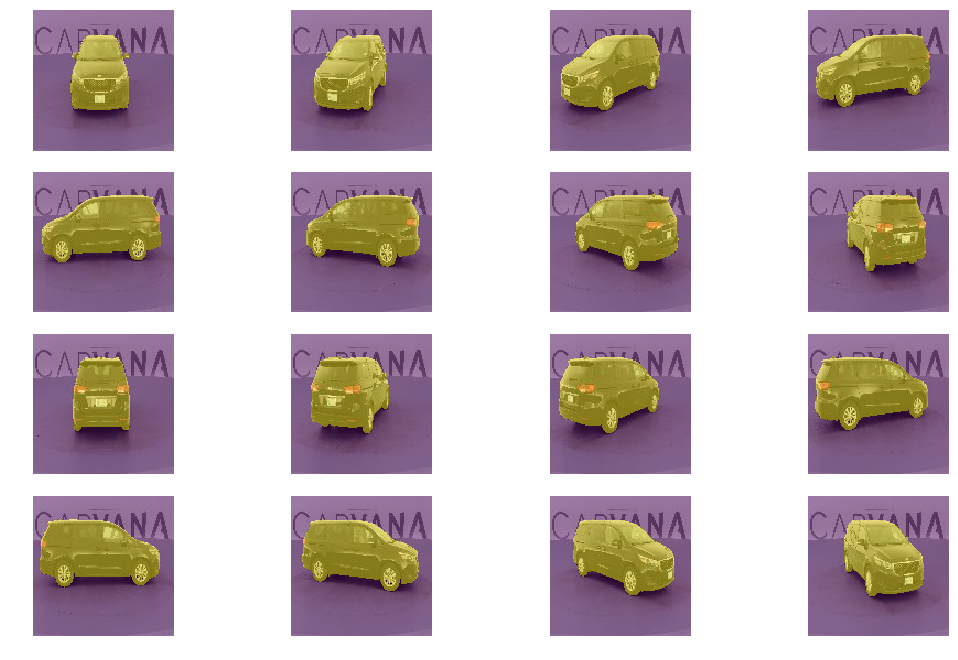

In [19]:
fig, axes = plt.subplots(4, 4, figsize=(15, 9))
for i, ax in enumerate(axes.flat):
    ax = show_img(imgs[i], ax=ax)
    show_img(masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

## Dataset

In [20]:
sz = 128
bs = 64

In [10]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, filenames, y, transform, path):
        self.y = y
        assert(len(filenames) == len(y))
        super().__init__(filenames, transform, path)
        
    def get_y(self, idx):
        return open_image(os.path.join(self.path, self.y[idx]))
    
    def get_c(self): return 0

In [22]:
mask_csv.head(2)

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...


In [23]:
inputs = np.array([Path(TRAIN_DIRNAME)/o for o in mask_csv['img']])

In [24]:
inputs[:2]

array([PosixPath('train-128/00087a6bd4dc_01.jpg'), PosixPath('train-128/00087a6bd4dc_02.jpg')], dtype=object)

In [25]:
labels = np.array([Path(MASK_DIRNAME)/f'{o[:-4]}_mask.png' for o in mask_csv['img']])

In [26]:
labels[:2]

array([PosixPath('train_masks-128/00087a6bd4dc_01_mask.png'),
       PosixPath('train_masks-128/00087a6bd4dc_02_mask.png')], dtype=object)

#### Train-test-split

For this dataset it is crucial that we do not choose random validation indices: we want to validate on cars the network has never seen in any other position. We therefore choose the *first n* samples in the dataset.

In [27]:
len(inputs), len(labels)

(5088, 5088)

In [28]:
val_indcs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_indcs, inputs, labels)

#### Data augmentation

In [30]:
aug_transforms = [RandomRotate(4, tfm_y=TfmType.CLASS),
                 RandomFlip(tfm_y=TfmType.CLASS),
                 RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]
# TfmType.CLASS will make sure that the labels do not get normalized or interpolated after rotation

In [31]:
transforms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_transforms)

#### modeldata object

In [32]:
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), transforms, path=PATH)

In [33]:
datasets

 None,
 None]

In [34]:
modeldata = ImageData(PATH, datasets, bs, num_workers=12, classes=None)

In [35]:
x, y = next(iter(modeldata.val_dl))

In [36]:
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 128, 128]))

In [37]:
x = modeldata.val_ds.denorm(x)

In [38]:
x.shape, y.shape

((64, 128, 128, 3), torch.Size([64, 128, 128]))

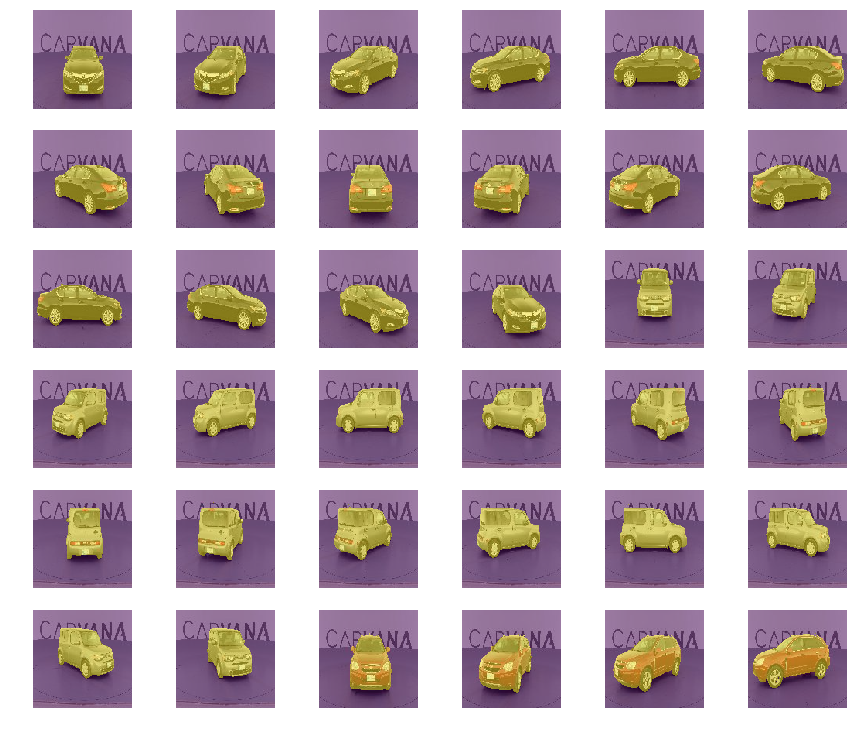

In [39]:
fig, axes = plt.subplots(6, 6, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    ax = show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

# Models

## Simple upsampling from output of truncated resnet backbone

In [11]:
backbone = resnet34

In [12]:
cut, lr_cut = model_meta[backbone]

In [13]:
cut, lr_cut  # were classification layers need to be truncated and where to seperate into layer groups

(8, 6)

**Truncate the final pooling and classification layers:**

In [14]:
def get_base():
    layers = cut_model(backbone(True), cut)
    return nn.Sequential(*layers)

In [93]:
model_base = get_base()

#### Upsampling

In [94]:
class StdUpsample(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_in, n_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, x):
        return self.bn(F.relu(self.conv(x)))

In [95]:
class UpsampleResnet34(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.features = nn.Sequential(
            backbone,
            nn.ReLU(),
            StdUpsample(512, 256),
            StdUpsample(256, 256),
            StdUpsample(256, 256),
            StdUpsample(256, 256),
            nn.ConvTranspose2d(256, 1, 2, stride=2)
        )
    
    def forward(self, x):
        return self.features(x)[:, 0]
    
# [:, 0] converts shape from torch.Size([64, 1, 128, 128]) to torch.Size([64, 128, 128])

`split_by_idxs(seq, idxs)`: A generator that returns sequence pieces, seperated by indices specified in idxs. 

**Important note to self: this is a cool example of how you can take a fastai/pytorch model and split it into layer groups for gradual unfreezing during training!**

In [96]:
class UpsampleModel():
    def __init__(self, model, name="upsample"):
        self.model, self.name = model, name
    
    def get_layer_groups(self, precompute):
        # Get the layer groups from the backbone:
        # model_meta dict contains info where to split predefined models
        layer_groups = list(split_by_idxs(list(self.model.backbone.children()), [lr_cut]))
        # and add the upsampling part. Starting from 1 so that backbone is not included again (see cell above)
        return layer_groups + [list(self.model.features.children())[1:]]  

In [97]:
model = to_gpu(UpsampleResnet34(model_base))

In [98]:
upsample_model = UpsampleModel(model)

#### Metric: Dice-index (similar to Jacquard index)

In [15]:
def dice(pred, targ):
    pred = (pred>0).float()
    return 2. * (pred * targ).sum() / (pred + targ).sum()

In [100]:
learn = ConvLearner(modeldata, upsample_model)

In [101]:
learn.opt_fn = optim.Adam

In [102]:
learn.crit = nn.BCEWithLogitsLoss()

In [103]:
learn.metrics = [accuracy_thresh(0.5), dice]

In [16]:
#learn.summary()

In [105]:
len(upsample_model.get_layer_groups(False))

3

In [106]:
upsample_model.get_layer_groups(False)[2]

[ReLU(), StdUpsample(
   (conv): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
   (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ), StdUpsample(
   (conv): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
   (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ), StdUpsample(
   (conv): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
   (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ), StdUpsample(
   (conv): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
   (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ), ConvTranspose2d(256, 1, kernel_size=(2, 2), stride=(2, 2))]

```
    def freeze_to(self, n):
        c=self.get_layer_groups()
        for l in c:     set_trainable(l, False)
        for l in c[n:]: set_trainable(l, True)
```

**Freezes the first layer group (first part of truncated backbone until layer 'lr_cut').**

In [107]:
learn.freeze_to(1)

In [108]:
# learn.get_layer_groups()[1:]

In [109]:
learn.lr_find()

 84%|████████▍ | 54/64 [00:06<00:01,  7.76it/s, loss=2.04] 


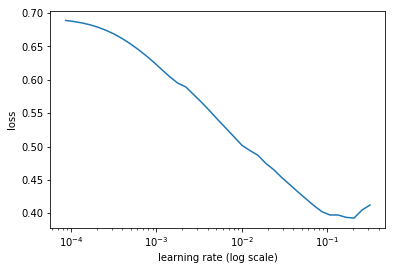

In [110]:
learn.sched.plot()

In [111]:
len(learn.get_layer_groups())

3

In [112]:
lr = 4e-2
wd = 1e-7
lrs = np.array([lr/100, lr/10, lr])

In [113]:
learn.fit(lr, n_cycle=1, wds=wd, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.125046   0.054136   0.977498   0.945561  
    1      0.063067   0.043116   0.981618   0.956625        
    2      0.042079   0.034385   0.986888   0.96632         
    3      0.033558   0.029287   0.987984   0.971574        



[0.02928725074207972, 0.9879835219610305, 0.9715741693027435]

**Unfreeze all layers except batchnorm and train with differential learning rates:**

In [114]:
learn.unfreeze()

In [115]:
learn.bn_freeze(True)

In [121]:
learn.fit(lrs, n_cycle=1, wds=wd, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice          
    0      15.531835  0.282062   0.858697   0.72137   
    1      3.468745   0.088245   0.96324    0.913483      
    2      0.94796    0.055943   0.976548   0.944456       
    3      0.29331    0.048813   0.979519   0.951463       



[0.0488125185763079, 0.9795189518777151, 0.9514634949820382]

In [122]:
learn.fit(lrs/2, n_cycle=1, wds=wd, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.047699   0.043578   0.979431   0.955317  
    1      0.040003   0.036321   0.985022   0.964178        
    2      0.035552   0.033898   0.985927   0.966713        
    3      0.032599   0.032055   0.986372   0.96864         



[0.032054951266636926, 0.9863720838985746, 0.968639664233677]

In [123]:
learn.save('upsample_128')

**Let's look at a prediction:**

In [124]:
x, y = next(iter(modeldata.val_dl))

In [125]:
pred_mask = learn.model(x)

In [127]:
pred_mask = pred_mask.data.cpu().numpy()

In [128]:
pred_mask.shape

(64, 128, 128)

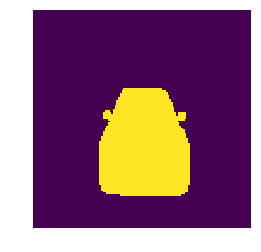

In [132]:
show_img(y[0])

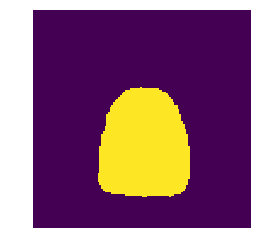

In [133]:
show_img(pred_mask[0]>0)

**That is a pretty *unusable* predicted mask! More like a round blop. The mirrors are completely missing! This happens because we ask the network to do a very difficult thing! The input image is reduced to a size of 512x4x4 and the network has to encode the entire information in this downsampled tensor. This is where *U-Net* comes into play.**

# U-Net
Note, that the shapes of the filters are not the same as in the paper because this notebook uses a pretrained resnet34 backbone and the upsampling steps have been adjusted accordingly!

In [17]:
class SaveFeatures():
    features = None
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def remove(self):
        self.hook.remove()

In [18]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out): 
        # up_in from prev 'upsampling' layer. x_in from the forward_hook from the backbone
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv = nn.Conv2d(x_in, x_out, kernel_size=1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, kernel_size=2, stride=2)  
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)  # doubles the size to make it the same as the x_p
        x_p  = self.x_conv(x_p)
        cat_p = torch.cat([up_p, x_p], dim=1)  # channel dimension
        return self.bn(F.relu(cat_p))

In [19]:
# model = resnet34(True)

In [68]:
list(model.children())[6][5]

BasicBlock(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [20]:
class Unet34(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.saveFeat = [SaveFeatures(backbone[i]) for i in [2,4,5,6]]  # [3] is MaxPool2d
        self.up1 = UnetBlock(512,256,256)  # list(model.children())[6][5]
        self.up2 = UnetBlock(256,128,256)  # look at list(model.children())[5][3] to understand the 128
        self.up3 = UnetBlock(256,64,256)   # A few cells below you also find the shapes of saveFeat
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256, 3, 16)
        self.up6 = nn.ConvTranspose2d(16, 1, kernel_size=1)
        
    def forward(self, x):
        #pdb.set_trace()
        inp = x                                     # All shapes assume an input size of [64, 3, 128, 128]
        x = F.relu(self.backbone(x))                # [64, 512, 4, 4] output of backbone
        x = self.up1(x, self.saveFeat[3].features)  # [64, 256, 8, 8]
        x = self.up2(x, self.saveFeat[2].features)  # [64, 256, 16, 16]
        x = self.up3(x, self.saveFeat[1].features)  # [64, 256, 32, 32]
        x = self.up4(x, self.saveFeat[0].features)  # [64, 256, 64, 64]
        x = self.up5(x, inp)                        # [64, 16, 128, 128]
        x = self.up6(x)                             # [64, 1, 128, 128]
        return x[:,0]
    
    def close(self):
        for o in self.saveFeat: o.remove()

In [21]:
class UnetModel():
    def __init__(self, model, name="unet_model"):
        self.model, self.name = model, name
    
    def get_layer_groups(self, precompute):
        layer_groups = list(split_by_idxs(list(self.model.backbone.children()), [lr_cut]))  # splits backbone
        return layer_groups + [list(self.model.children())[1:]]  # [1:] excludes backbone

In [88]:
model_base = get_base()

In [89]:
model = Unet34(model_base).cuda()

In [90]:
unet_model = UnetModel(model)

In [91]:
learn = ConvLearner(modeldata, unet_model)

learn.opt_fn = optim.Adam

learn.crit = nn.BCEWithLogitsLoss()

learn.metrics = [accuracy_thresh(0.5), dice]

In [84]:
x, y = next(iter(modeldata.val_dl))

In [96]:
model(x);

In [98]:
model.saveFeat

In [100]:
[h.features.size() for h in model.saveFeat]

[torch.Size([64, 64, 64, 64]),
 torch.Size([64, 64, 32, 32]),
 torch.Size([64, 128, 16, 16]),
 torch.Size([64, 256, 8, 8])]

In [116]:
learn.freeze_to(1)  # freezes the pretrained backbone

In [117]:
learn.lr_find()

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.638764   5505568.468254 0.487506   0.329145  



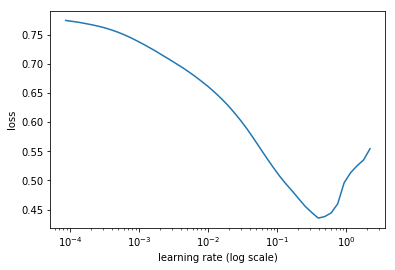

In [118]:
learn.sched.plot()

In [119]:
lr = 4e-2
wd = 1e-7

In [120]:
learn.fit(lr, n_cycle=1, cycle_len=8, use_clr=(5, 8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.09899    0.028628   0.988741   0.973076  
    1      0.041071   0.023525   0.990525   0.977535        
    2      0.026865   0.022946   0.991325   0.978474        
    3      0.022409   0.020584   0.991341   0.98078         
    4      0.019899   0.021318   0.992459   0.980424        
    5      0.018481   0.019668   0.992497   0.981729        
    6      0.017441   0.018141   0.992348   0.983074        
    7      0.016368   0.017299   0.993078   0.984045        



[0.01729911312993084, 0.9930776556332906, 0.9840451346503364]

In [121]:
learn.save('128_unet')

In [122]:
learn.load('128_unet')

In [123]:
learn.unfreeze()
learn.bn_freeze(True)

In [127]:
learn.get_layer_groups()[2]

[UnetBlock(
   (x_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
   (tr_conv): ConvTranspose2d(512, 128, kernel_size=(2, 2), stride=(2, 2))
   (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ), UnetBlock(
   (x_conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
   (tr_conv): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
   (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ), UnetBlock(
   (x_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
   (tr_conv): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
   (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ), UnetBlock(
   (x_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
   (tr_conv): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
   (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ), UnetBlock(
   (x_conv

In [128]:
lrs = np.array([lr/200, lr/20, lr])/2

In [129]:
learn.fit(lrs, n_cycle=1, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.015996   0.018432   0.992467   0.982935  
    1      0.015263   0.016657   0.993695   0.98476         
    2      0.014711   0.016914   0.993866   0.984657        
    3      0.014404   0.015784   0.993885   0.985516        
    4      0.013989   0.015808   0.993664   0.985579        
    5      0.013601   0.015723   0.99412    0.985761        
    6      0.013266   0.015201   0.994005   0.986233        
    7      0.012946   0.015031   0.994154   0.986457        
    8      0.012821   0.014864   0.994274   0.986649        
    9      0.012639   0.014899   0.994302   0.986683        



[0.014899190825720629, 0.9943020533001612, 0.9866834595089867]

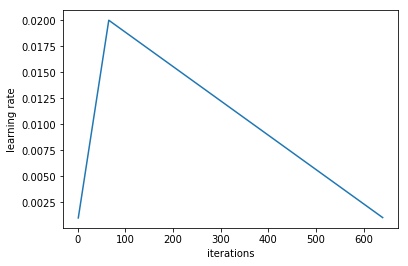

In [130]:
learn.sched.plot_lr()

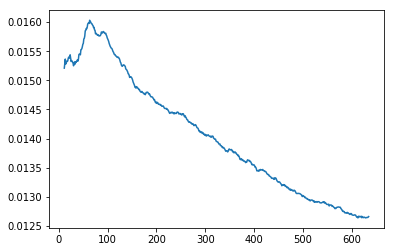

In [131]:
learn.sched.plot_loss()

In [132]:
learn.save('128_unet2')

In [133]:
learn.load('128_unet2')

In [134]:
x, y = next(iter(modeldata.val_dl))

In [135]:
pred_mask = learn.model(x)

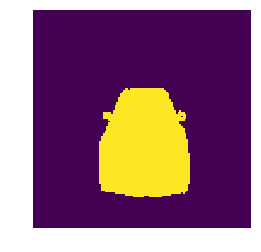

In [149]:
show_img(pred_mask[0]>0)

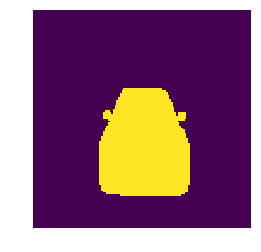

In [150]:
show_img(y[0])

**Not too bad, right? :)**

In [151]:
model.close()  # removes the hooks to free device memory

## Progressive resizing

### 512x512

In [199]:
sz = 512
bs = 8

In [22]:
TRAIN_DIRNAME = 'train'
MASK_DIRNAME = 'train_masks_png'

In [23]:
inputs = np.array([Path(TRAIN_DIRNAME)/o for o in mask_csv['img']])

In [24]:
labels = np.array([Path(MASK_DIRNAME)/f'{o[:-4]}_mask.png' for o in mask_csv['img']])

In [25]:
val_indcs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_indcs, inputs, labels)

In [204]:
aug_transforms = [RandomRotate(4, tfm_y=TfmType.CLASS),
                 RandomFlip(tfm_y=TfmType.CLASS),
                 RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

transforms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_transforms)

datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), transforms, path=PATH)

modeldata = ImageData(PATH, datasets, bs, num_workers=12, classes=None)

In [205]:
model_base = get_base()
model = Unet34(model_base).cuda()
unet_model = UnetModel(model)

In [206]:
learn = ConvLearner(modeldata, unet_model)

learn.opt_fn = optim.Adam

learn.crit = nn.BCEWithLogitsLoss()

learn.metrics = [accuracy_thresh(0.5), dice]

In [207]:
learn.freeze_to(1)  # freezing the backbone

In [208]:
learn.load('128_unet2')

In [209]:
learn.lr_find()

 89%|████████▉ | 453/510 [02:46<00:20,  2.73it/s, loss=0.072] 

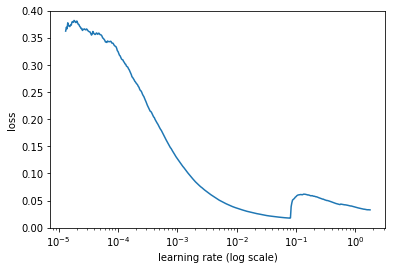

In [210]:
learn.sched.plot()

In [211]:
lr=2e-3
wd=1e-7

In [212]:
learn.fit(lr, n_cycle=1, wds=wd, cycle_len=5, use_clr=(5,5))

  1%|          | 4/510 [00:06<13:08,  1.56s/it, loss=0.31] 
epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.010364   0.01023    0.996202   0.99126   
    1      0.007986   0.008455   0.996796   0.992353           
    2      0.007372   0.007525   0.997123   0.993224           
    3      0.006683   0.007136   0.997104   0.993499           
    4      0.006332   0.006794   0.99723    0.993712           



[0.006794058998662328, 0.9972302156781393, 0.9937117752574739]

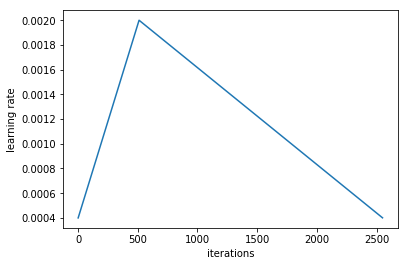

In [217]:
learn.sched.plot_lr()

In [213]:
learn.save('512_unet')

In [214]:
learn.load('512_unet')

In [216]:
learn.unfreezeze()
learn.bn_freeze(True)

In [215]:
lrs = np.array([lr/200, lr/20, lr])/2

In [218]:
learn.fit(lrs/2, n_cycle=1, wds=wd, cycle_len=8, use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice               
    0      0.006011   0.006597   0.99734    0.993917  
    1      0.00587    0.006531   0.997305   0.993987           
    2      0.005791   0.006429   0.997455   0.994079           
    3      0.005795   0.006366   0.99739    0.994124           
    4      0.005704   0.006291   0.997478   0.994204           
    5      0.00561    0.006285   0.997446   0.994217           
    6      0.005531   0.006234   0.997525   0.99427            
    7      0.005541   0.006214   0.997517   0.99428            



[0.006213826478444158, 0.9975168932051885, 0.994279569576657]

In [219]:
learn.save('512_unet2')

In [220]:
learn.load('512_unet2')

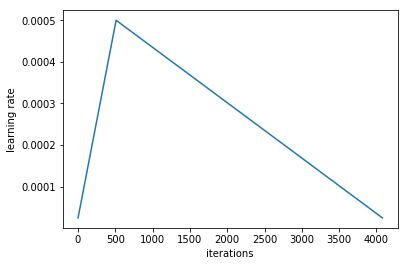

In [221]:
learn.sched.plot_lr()

In [222]:
x, y = next(iter(modeldata.val_dl))

In [223]:
x.shape, y.shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 512, 512]))

In [224]:
pred_mask = learn.model(x)

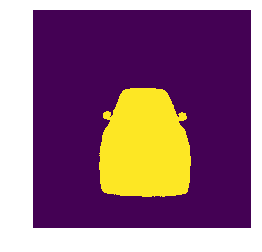

In [225]:
show_img(pred_mask[0]>0)

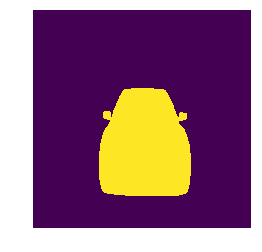

In [226]:
show_img(y[0])

In [227]:
model.close()

### 1024x1024

In [26]:
sz = 1024
bs = 4

In [27]:
aug_transforms = [RandomRotate(4, tfm_y=TfmType.CLASS),
                 RandomFlip(tfm_y=TfmType.CLASS),
                 RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

transforms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_transforms)

datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), transforms, path=PATH)

modeldata = ImageData(PATH, datasets, bs, num_workers=12, classes=None)

In [28]:
model_base = get_base()
model = Unet34(model_base).cuda()
unet_model = UnetModel(model)

In [29]:
x, y = next(iter(modeldata.val_dl))

In [30]:
x.shape, y.shape

(torch.Size([4, 3, 1024, 1024]), torch.Size([4, 1024, 1024]))

In [31]:
learn = ConvLearner(modeldata, unet_model)

learn.opt_fn = optim.Adam

learn.crit = nn.BCEWithLogitsLoss()

learn.metrics = [accuracy_thresh(0.5), dice]

In [32]:
learn.freeze_to(1)  # freezing the backbone

In [33]:
learn.load('512_unet2')

In [34]:
learn.lr_find()

 70%|██████▉   | 711/1020 [05:47<02:31,  2.04it/s, loss=0.0243] 

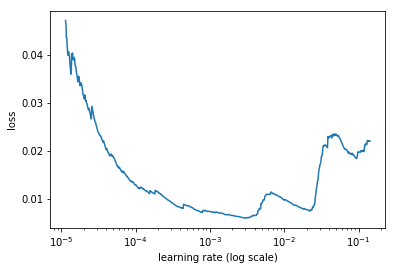

In [35]:
learn.sched.plot()

In [36]:
lr=1e-4
wd=1e-7

In [38]:
learn.fit(lr, n_cycle=1, wds=wd, cycle_len=2, use_clr=(5,4))

  0%|          | 3/1020 [00:04<25:18,  1.49s/it, loss=0.00475]  
epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.004725   0.005242   0.997962   0.995324  
    1      0.004679   0.005023   0.998033   0.995465             



[0.005022997655610126, 0.9980327165316022, 0.995464565971541]

In [39]:
learn.save('1024_unet')

In [40]:
learn.load('1024_unet')

In [41]:
learn.unfreeze()

In [42]:
learn.bn_freeze(True)

In [44]:
lrs = np.array([lr/2000, lr/300, lr/10])

In [45]:
learn.fit(lr, n_cycle=1, wds=wd, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.004843   0.005399   0.997949   0.995284  
    1      0.004476   0.005219   0.998078   0.995387             
    2      0.004232   0.004999   0.998085   0.995585             
    3      0.004223   0.004918   0.998116   0.995614             



[0.00491824994854156, 0.9981157826998878, 0.9956142703692118]

In [46]:
learn.fit(lr, n_cycle=1, wds=wd, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.004319   0.004788   0.998089   0.995688  
    1      0.004256   0.004578   0.998228   0.99581              
    2      0.004136   0.004561   0.99823    0.99584              
    3      0.004048   0.004458   0.998247   0.995929             



[0.00445752248485824, 0.9982474805816771, 0.995929234794208]

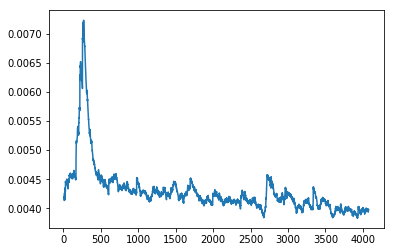

In [47]:
learn.sched.plot_loss()

In [48]:
learn.save('1024_unet2')

In [49]:
x, y = next(iter(modeldata.val_dl))

In [51]:
pred_mask = learn.model(x)

#### Prediction

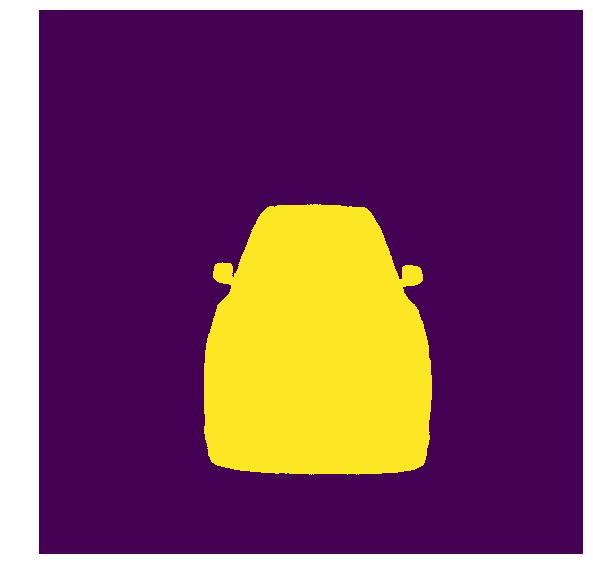

In [54]:
show_img(pred_mask[0]>0, figsize=(10,10))

#### Label

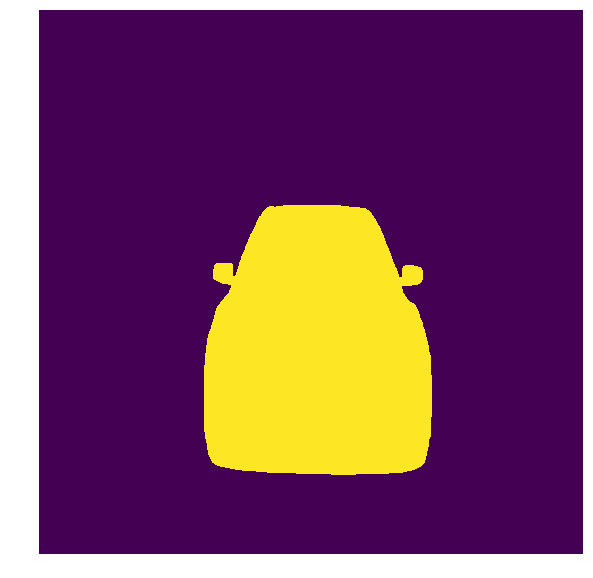

In [55]:
show_img(y[0], figsize=(10,10))

### Awesome :D